# I. Tiền xử lý dữ liệu Daily Data


Khai báo các thư viện cần sử dụng

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, TargetEncoder
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
import scipy.stats as stats

In [59]:
PREDICTION_OFFSET_DAYS = 1
WINDOW_SIZE = 7

## 1. Xử lý missing values

In [60]:
df = pd.read_csv(r'../data/processed/merged_daily_data.csv')
df.head()

,itemid,shopid,liked_count,cmt_count,discount,shop_location,shop_rating,name,historical_sold,price,rating_star,rating_count,rcount_with_context,date
0,7519041067,233692311,15491,32829,19%,TP. Hồ Chí Minh,4.859500,Dung dịch làm sạch và tẩy trang công nghệ Mice...,113504,4.250000e+10,4.863410,32831,16938,2024-03-10
1,6219027671,233692311,1371,3573,20%,TP. Hồ Chí Minh,4.859495,Dung dịch làm sạch và tẩy trang công nghệ Mice...,9100,1.800000e+10,4.928291,3573,1740,2024-03-10
2,4819028193,233692311,6052,16079,20%,TP. Hồ Chí Minh,4.859496,Dung dịch làm sạch và tẩy trang công nghệ Mice...,52577,4.200000e+10,4.830832,16079,8934,2024-03-10
3,7219040496,233692311,1754,4697,20%,TP. Hồ Chí Minh,4.859495,Dung dịch làm sạch và tẩy trang công nghệ Mice...,13350,1.800000e+10,4.932467,4697,2408,2024-03-10
4,3128937646,233692311,597,974,5%,TP. Hồ Chí Minh,4.859495,"Gel rửa mặt tạo bọt, không chứa xà phòng Biode...",3261,1.950000e+10,4.710175,974,604,2024-03-10


In [61]:
keywords_pattern = r'\[HB GIFT\]|\[Quà tặng\]|\[Gift\]|\[HC Gift\]|không bán|\[Tặng kèm\]'
df = df[~df['name'].str.contains(keywords_pattern, case=False, regex=True)]
print("Kích thước DataFrame sau khi lọc quà tặng:", df.shape)


Kích thước DataFrame sau khi lọc quà tặng: (137969, 14)


In [62]:
df.dtypes

itemid                   int64
shopid                   int64
liked_count              int64
cmt_count                int64
discount                object
shop_location           object
shop_rating            float64
name                    object
historical_sold          int64
price                  float64
rating_star            float64
rating_count             int64
rcount_with_context      int64
date                    object
dtype: object

Dữ liệu cmt_count gần bằng rating_count nên chúng ta sẽ drop bớt vì chúng mang cùng ý nghĩa. Số lượng bình luận sẽ tính bằng rcount_with_context

In [63]:
df = df.drop(columns=['cmt_count'])

Check xem có dữ liệu trùng cả itemid, shopid và date không?

Kiểm tra trùng lặp `itemid` giữa các shop


In [64]:
df.groupby('itemid')['shopid'].nunique().sort_values(ascending=False)


itemid
188449219      1
19556094612    1
19531064423    1
19530958648    1
19528564050    1
              ..
7231062004     1
7225166138     1
7222082416     1
7221329568     1
25972627110    1
Name: shopid, Length: 5303, dtype: int64


Trong dữ liệu này, Không có itemid nào được bán ở 2 shop khác nhau.

Do đó, chúng ta có thể sử dụng itemid để phân loại sản phẩm luôn, mà không cần nhóm sản phẩm theo shopid.

In [65]:
df.duplicated(subset=['itemid', 'date']).sum()

0

Không có dữ liệu itemid và date trùng lặp

Kiểm tra dữ liệu null

In [66]:
df.isnull().sum()

itemid                     0
shopid                     0
liked_count                0
discount               25539
shop_location              0
shop_rating                0
name                       0
historical_sold            0
price                      0
rating_star                0
rating_count               0
rcount_with_context        0
date                       0
dtype: int64

Kết quả cho thấy có 32170 giá trị discount null. Điều này có nghĩa là một phần đáng kể dữ liệu về giảm giá bị thiếu hoặc không tồn tại.

In [67]:
df['discount'].unique()

array(['19%', '20%', '5%', '15%', '10%', nan, '25%', '16%', '23%', '17%',
       '18%', '24%', '21%', '14%', '8%', '9%', '12%', '13%', '2%', '22%',
       '11%', '6%', '36%', '40%', '1%', '44%', '34%', '50%', '38%', '33%',
       '43%', '46%', '4%', '47%', '32%', '26%', '42%', '41%', '37%',
       '30%', '48%', '51%', '29%', '39%', '27%', '35%', '31%', '7%',
       '45%', '28%', '49%', '52%', '53%', '3%', '54%', '56%', '58%',
       '62%', '57%', '78%', '55%', '60%', '61%', '59%', '91%', '80%',
       '90%', '83%', '67%', '74%', '88%', '96%', '98%', '63%', '66%',
       '70%', '79%', '68%', '84%', '85%'], dtype=object)

**Giá trị null**
* Cột 'discount' chứa các giá trị phần trăm giảm giá từ 1% đến 98%, cùng với giá trị null.

**Giả định:**
* Giá trị null ban đầu không được áp dụng giảm giá (0%).
* Các trường hợp không có discount mà có giá khác với giá max trong lịch sử giá của sản phẩm cũng được coi là 0 vì giá của sản phẩm trên Shopee có thể thay đổi.

**Giảm giá lớn**

* Một số sản phẩm có mức giảm giá rất cao.
* Theo tìm hiểu, Shopee có quy định về mức Discount so với giá gốc để tránh các hàng giá ảo.
* Việc xác định và xử lý các trường hợp giảm giá quá cao có thể cần thêm phân tích.


In [68]:
df['discount'].fillna('0%', inplace=True)

C:\Users\ducli\AppData\Local\Temp\ipykernel_2748\3212925172.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['discount'].fillna('0%', inplace=True)


**Xem các item có thu thập được đầy đủ các ngày không**

Chuyển date về đúng định dạng datetime

In [69]:
df['date'] = pd.to_datetime(df['date'])
print('Starting date:', df['date'].min())
print('Ending date:', df['date'].max())
print('Number of days:', df['date'].nunique())

Starting date: 2024-03-10 00:00:00
Ending date: 2024-04-09 00:00:00
Number of days: 31


Xem các item có thu thập được đầy đủ các ngày không

In [70]:
df.groupby('itemid')['date'].nunique().sort_values(ascending=False)

itemid
11742214790    31
14682646891    31
14298156241    31
14298274533    31
14299512723    31
               ..
2251100046      1
2226853992      1
2173523453      1
17515301662     1
15095262977     1
Name: date, Length: 5303, dtype: int64

Xem tỉ lệ dữ liệu thiếu

In [71]:
df['count_date'] = df.groupby('itemid')['date'].transform('count')
print(df['count_date'].value_counts())

count_date
31    102207
30      7800
29      4089
28      2520
27      2484
26      2262
25      2175
24      1416
22      1144
21      1134
20      1100
18      1026
19       931
15       870
16       784
23       782
17       714
12       588
13       572
14       532
11       484
9        414
10       340
8        280
6        246
3        222
2        212
5        200
4        184
7        133
1        124
Name: count, dtype: int64


Một phần dữ liệu không thu thập được đầy đủ trong 31 ngày: có thể do lỗi ETL, sản phẩm bị lỗi hoặc bị xóa khỏi sản. 

In [72]:
df = df[df['count_date'] == 31]
df.drop(columns='count_date', inplace=True)


## 2. Xử lý dữ liệu dạng chuỗi


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102207 entries, 12 to 144620
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   itemid               102207 non-null  int64         
 1   shopid               102207 non-null  int64         
 2   liked_count          102207 non-null  int64         
 3   discount             102207 non-null  object        
 4   shop_location        102207 non-null  object        
 5   shop_rating          102207 non-null  float64       
 6   name                 102207 non-null  object        
 7   historical_sold      102207 non-null  int64         
 8   price                102207 non-null  float64       
 9   rating_star          102207 non-null  float64       
 10  rating_count         102207 non-null  int64         
 11  rcount_with_context  102207 non-null  int64         
 12  date                 102207 non-null  datetime64[ns]
dtypes: datetime64[ns](

Chuyển discount về dạng số

In [74]:
df['discount'] = df['discount'].str.replace('%', '').astype(int)

Xem định dạng của vị trí của các shop

In [75]:
df.groupby('shopid')['shop_location'].unique()

shopid
18363975                        [Hà Nội]
18582774                        [Hà Nội]
18644537               [TP. Hồ Chí Minh]
37251700               [TP. Hồ Chí Minh]
37251933               [TP. Hồ Chí Minh]
95753434     [TP. Hồ Chí Minh, Bắc Ninh]
111138057    [TP. Hồ Chí Minh, Bắc Ninh]
151657812              [TP. Hồ Chí Minh]
157995825              [TP. Hồ Chí Minh]
175753395              [TP. Hồ Chí Minh]
175889782                       [Hà Nội]
233692311    [TP. Hồ Chí Minh, Bắc Ninh]
421677475              [TP. Hồ Chí Minh]
Name: shop_location, dtype: object

Cột shop_location hiện đang ở dạng text, điều này có thể gây khó khăn cho các mô hình học máy trong việc xử lý dữ liệu. Để giải quyết vấn đề này, chúng ta có thể thực hiện mã hóa ở phần sau.

Xem lại dữ liệu

In [76]:
df.dtypes

itemid                          int64
shopid                          int64
liked_count                     int64
discount                        int32
shop_location                  object
shop_rating                   float64
name                           object
historical_sold                 int64
price                         float64
rating_star                   float64
rating_count                    int64
rcount_with_context             int64
date                   datetime64[ns]
dtype: object

## 3. Feature Engineering

### a. Local Features

In [77]:
df.columns

Index(['itemid', 'shopid', 'liked_count', 'discount', 'shop_location',
       'shop_rating', 'name', 'historical_sold', 'price', 'rating_star',
       'rating_count', 'rcount_with_context', 'date'],
      dtype='object')

Tạo cột date_of_week

In [78]:
df['date_of_week'] = df['date'].dt.dayofweek
df['day'] = df['date'].dt.day


Tạo cột special_date dựa vào 3 ngày lễ sale của Shopee

In [79]:
special_dates = [pd.to_datetime('2024-03-15'), pd.to_datetime('2024-03-15'), pd.to_datetime('2024-04-04')]

# Create 'is_special_day' column
df['is_special_day'] = df['date'].isin(special_dates).astype(int)
df['future_special_day'] = df['is_special_day'].shift(-PREDICTION_OFFSET_DAYS).fillna(0).astype(int)

Tạo cột daily_sales là số lượng bán được ( ngày sau trừ ngày liền trước ).

In [80]:
df.sort_values(by=['itemid','date'], inplace=True)
df['daily_sales'] = df.groupby('itemid')['historical_sold'].diff()

# Quan sát dữ liệu
df[df['itemid'] == 188787501][['date', 'historical_sold', 'daily_sales']].head(10)

,date,historical_sold,daily_sales
13603,2024-03-10,6960,NaN
15214,2024-03-11,6967,7.0
16734,2024-03-12,6967,0.0
18182,2024-03-13,6969,2.0
19591,2024-03-14,6971,2.0
21026,2024-03-15,6975,4.0
22464,2024-03-16,6981,6.0
23906,2024-03-17,6986,5.0
25358,2024-03-18,6988,2.0
26790,2024-03-19,6994,6.0


In [81]:
df['daily_sales'].describe()

count    98910.000000
mean        16.712587
std        111.870950
min        -28.000000
25%          0.000000
50%          1.000000
75%          5.000000
max       5633.000000
Name: daily_sales, dtype: float64

Dữ liệu trong cột daily_sales cho thấy:

- Số lượng giá trị: Có  98,910 giá trị không bị thiếu.
- Giá trị trung bình: Trung bình mỗi ngày bán được khoảng 16.71 sản phẩm.
- Độ lệch chuẩn: 111.87, cho thấy sự phân bố khá rộng so với giá trị trung bình.
- Giá trị nhỏ nhất: -28, điều này khá lạ vì không thể có số sản phẩm bán ra là âm
- Giá trị lớn nhất: 15633, rất cao so với các giá trị khác và có thể là một giá trị ngoại lai.

Kiểm tra trường hợp daily_sales bị âm

In [82]:
df[df['daily_sales'] < 0].count()

itemid                 19
shopid                 19
liked_count            19
discount               19
shop_location          19
shop_rating            19
name                   19
historical_sold        19
price                  19
rating_star            19
rating_count           19
rcount_with_context    19
date                   19
date_of_week           19
day                    19
is_special_day         19
future_special_day     19
daily_sales            19
dtype: int64

In [83]:
#df[df['daily_sales'] < 0]

In [84]:
df[df['daily_sales'] < 0].groupby('shopid')['daily_sales'].count().sort_values(ascending=False)

shopid
175889782    19
Name: daily_sales, dtype: int64

In [85]:
df[df['daily_sales'] < 0].groupby('date')['daily_sales'].count().sort_values(ascending=False)

date
2024-03-29    19
Name: daily_sales, dtype: int64

In [86]:
df[df['daily_sales'] < 0]['daily_sales'].sum()


-114.0

Có 19 trường hợp daily_sales bị âm, đều thuộc về shop 1715889782, vào ngày 2024-03-29, tổng cộng -114 sản phẩm. Đây có thể là do cách tính toán của shopee, phạt đơn ảo, trả hàng, hủy đơn, thiếu hàng,... nên ta sẽ điền median vào những giá trị âm này.

In [87]:
# Tính median daily_sales cho mỗi itemid
median_sales = df[df['daily_sales'] >= 0].groupby('itemid')['daily_sales'].median()

# Tạo một hàm để áp dụng median
def replace_with_median(row):
    if row['daily_sales'] < 0:
        return median_sales[row['itemid']]
    return row['daily_sales']

# Áp dụng hàm để thay thế giá trị daily_sales
df['daily_sales'] = df.apply(replace_with_median, axis=1)


Loại bỏ df ngày 10/3, vì ngày này không có dữ liệu historical_sold của ngày 9/3 để tính daily_sales nên không có ý nghĩa trong mô hình

In [88]:
df = df[df['date'] != pd.to_datetime('2024-03-10')]

In [89]:
df.shape

(98910, 18)

In [90]:
df['daily_sales'].describe()

count    98910.000000
mean        16.734698
std        112.044801
min          0.000000
25%          0.000000
50%          1.000000
75%          5.000000
max       5633.000000
Name: daily_sales, dtype: float64

In [91]:
df['daily_sales'].value_counts().sort_index()

daily_sales
0.0       47802
1.0       11755
2.0        6252
3.0        4101
4.0        2990
          ...  
4616.0        1
4787.0        1
4990.0        1
5613.0        1
5633.0        1
Name: count, Length: 876, dtype: int64

Lọc bỏ các item có daily_sales là outlier

In [92]:
df.shape

(98910, 18)

c:\Users\ducli\miniconda3\envs\KLTN\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


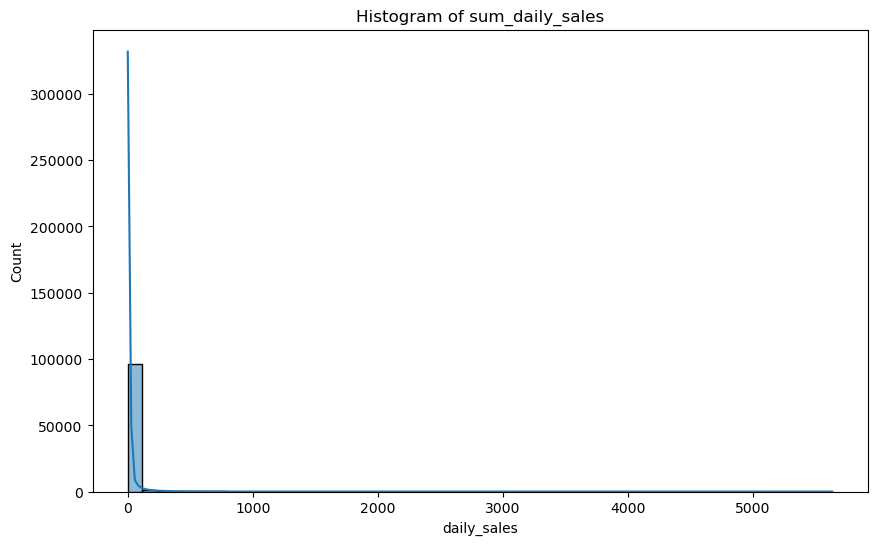

In [36]:
# Vẽ histogram của 'sum_daily_sales'
plt.figure(figsize=(10, 6))
sns.histplot(df['daily_sales'], bins=50, kde=True)
plt.title('Histogram of sum_daily_sales')
plt.show()

In [37]:
# Giả sử grouped_df là dataframe của bạn chứa cột 'sum_daily_sales'
data = np.log1p(df['daily_sales'])

# Tính giá trị Q1 (25th percentile) và Q3 (75th percentile)
Q1 = np.percentile(data, 25)
Q3 = np.percentile(data, 75)

# Tính IQR
IQR = Q3 - Q1

# Xác định ngưỡng dưới và ngưỡng trên
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Xác định outlier
outliers = df[(data < lower_bound) | (data > upper_bound)]

In [38]:
df = df[~df['itemid'].isin(outliers['itemid'])]

In [39]:
df.shape

(91650, 18)

Tạo thêm cột số lượng bán, giá bán của những ngày trước và ngày dự đoán

In [40]:
for i in range(1, WINDOW_SIZE + 1):
    df[f'daily_sales_lag_{i}d'] = df.groupby('itemid')['daily_sales'].shift(i)
    df[f'price_lag_{i}d'] = df.groupby('itemid')['price'].shift(i)

df['sales_predict_day'] = df.groupby('itemid')['daily_sales'].shift(-PREDICTION_OFFSET_DAYS)

# Điền giá trị trung bình cho các cột mới
new_columns = [f'daily_sales_lag_{i}d' for i in range(1, WINDOW_SIZE + 1)] + [f'price_lag_{i}d' for i in range(1, WINDOW_SIZE + 1)]
df[new_columns] = df.groupby('itemid')[new_columns].transform(lambda x: x.fillna(x.median()))
#giữ lại cho model sequency không cần dùng đến predict day nhưng lại cần daily_sale

#df.dropna(subset=['sales_predict_day'], inplace=True)

# Quan sát dữ liệu
item_to_view = 188787501
columns_to_view = ['date', 'historical_sold', 'sales_predict_day','daily_sales'] + [f'daily_sales_lag_{i}d' for i in range(1, WINDOW_SIZE + 1)] + [f'price_lag_{i}d' for i in range(1, WINDOW_SIZE + 1)]
view_data = df[df['itemid'] == item_to_view][columns_to_view]
view_data


,date,historical_sold,sales_predict_day,daily_sales,daily_sales_lag_1d,daily_sales_lag_2d,daily_sales_lag_3d,daily_sales_lag_4d,daily_sales_lag_5d,daily_sales_lag_6d,daily_sales_lag_7d,price_lag_1d,price_lag_2d,price_lag_3d,price_lag_4d,price_lag_5d,price_lag_6d,price_lag_7d
15214,2024-03-11,6967,0.0,7.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1.230000e+10,1.230000e+10,1.230000e+10,1.230000e+10,1.230000e+10,1.230000e+10,1.230000e+10
16734,2024-03-12,6967,2.0,0.0,7.0,4.0,4.0,4.0,4.0,4.0,4.0,1.250000e+10,1.230000e+10,1.230000e+10,1.230000e+10,1.230000e+10,1.230000e+10,1.230000e+10
18182,2024-03-13,6969,2.0,2.0,0.0,7.0,4.0,4.0,4.0,4.0,4.0,1.250000e+10,1.250000e+10,1.230000e+10,1.230000e+10,1.230000e+10,1.230000e+10,1.230000e+10
19591,2024-03-14,6971,4.0,2.0,2.0,0.0,7.0,4.0,4.0,4.0,4.0,1.250000e+10,1.250000e+10,1.250000e+10,1.230000e+10,1.230000e+10,1.230000e+10,1.230000e+10
21026,2024-03-15,6975,6.0,4.0,2.0,2.0,0.0,7.0,4.0,4.0,4.0,1.250000e+10,1.250000e+10,1.250000e+10,1.250000e+10,1.230000e+10,1.230000e+10,1.230000e+10
22464,2024-03-16,6981,5.0,6.0,4.0,2.0,2.0,0.0,7.0,4.0,4.0,1.250000e+10,1.250000e+10,1.250000e+10,1.250000e+10,1.250000e+10,1.230000e+10,1.230000e+10
23906,2024-03-17,6986,2.0,5.0,6.0,4.0,2.0,2.0,0.0,7.0,4.0,1.250000e+10,1.250000e+10,1.250000e+10,1.250000e+10,1.250000e+10,1.250000e+10,1.230000e+10
25358,2024-03-18,6988,6.0,2.0,5.0,6.0,4.0,2.0,2.0,0.0,7.0,1.250000e+10,1.250000e+10,1.250000e+10,1.250000e+10,1.250000e+10,1.250000e+10,1.250000e+10
26790,2024-03-19,6994,4.0,6.0,2.0,5.0,6.0,4.0,2.0,2.0,0.0,1.230000e+10,1.250000e+10,1.250000e+10,1.250000e+10,1.250000e+10,1.250000e+10,1.250000e+10
28235,2024-03-20,6998,3.0,4.0,6.0,2.0,5.0,6.0,4.0,2.0,2.0,1.230000e+10,1.230000e+10,1.250000e+10,1.250000e+10,1.250000e+10,1.250000e+10,1.250000e+10


In [41]:
df[f'rolling_min_{WINDOW_SIZE}d'] = df.groupby('itemid')['daily_sales'].transform(lambda x: x.rolling(window=WINDOW_SIZE, min_periods=1).min())

df[f'rolling_max_{WINDOW_SIZE}d'] = df.groupby('itemid')['daily_sales'].transform(lambda x: x.rolling(window=WINDOW_SIZE, min_periods=1).max())

df[f'rolling_mean_{WINDOW_SIZE}d'] = df.groupby('itemid')['daily_sales'].transform(lambda x: x.rolling(window=WINDOW_SIZE, min_periods=1).mean())

df[f'rolling_std_{WINDOW_SIZE}d'] = df.groupby('itemid')['daily_sales'].transform(lambda x: x.rolling(window=WINDOW_SIZE, min_periods=1).std())

# Điền giá trị trung vị cho các cột mới
# rolling_columns = [f'rolling_min_{WINDOW_SIZE}d', f'rolling_max_{WINDOW_SIZE}d', f'rolling_mean_{WINDOW_SIZE}d', f'rolling_std_{WINDOW_SIZE}d']
rolling_columns = [f'rolling_mean_{WINDOW_SIZE}d']

df[rolling_columns] = df.groupby('itemid')[rolling_columns].transform(lambda x: x.fillna(x.median()))

rolling_columns = [f'rolling_std_{WINDOW_SIZE}d']
df[rolling_columns] = df.groupby('itemid')[rolling_columns].transform(lambda x: x.fillna(x.median()))

# df[df['itemid'] == 188787501][['date', 'historical_sold', 'daily_sales', f'rolling_min_{WINDOW_SIZE}d', f'rolling_max_{WINDOW_SIZE}d', f'rolling_mean_{WINDOW_SIZE}d', f'rolling_std_{WINDOW_SIZE}d']].head(10)
df[df['itemid'] == 188787501][['date', 'historical_sold', 'daily_sales',  f'rolling_mean_{WINDOW_SIZE}d']].head(10)

,date,historical_sold,daily_sales,rolling_mean_7d
15214,2024-03-11,6967,7.0,7.000000
16734,2024-03-12,6967,0.0,3.500000
18182,2024-03-13,6969,2.0,3.000000
19591,2024-03-14,6971,2.0,2.750000
21026,2024-03-15,6975,4.0,3.000000
22464,2024-03-16,6981,6.0,3.500000
23906,2024-03-17,6986,5.0,3.714286
25358,2024-03-18,6988,2.0,3.000000
26790,2024-03-19,6994,6.0,3.857143
28235,2024-03-20,6998,4.0,4.142857


### b. Kết hợp với dữ liệu sentiment analyst


In [42]:
rv = pd.read_csv('..\data\processed\merged_reviews_minimal_with_bert.csv')

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\ducli\AppData\Local\Temp\ipykernel_2748\2960762617.py:1: SyntaxWarning: invalid escape sequence '\d'
  rv = pd.read_csv('..\data\processed\merged_reviews_minimal_with_bert.csv')


In [43]:
rv.dtypes

comment            object
itemid              int64
date               object
cmtid               int64
rating_star         int64
predicted_label     int64
probabilities      object
dtype: object

In [44]:
rv['predicted_label'].value_counts()

predicted_label
1    1827596
2     124480
0     123049
Name: count, dtype: int64

In [45]:
rv['datetime'] = pd.to_datetime(rv['date'])
rv['date'] = pd.to_datetime(rv['datetime'].dt.date)

In [46]:
rv.dtypes

comment                    object
itemid                      int64
date               datetime64[ns]
cmtid                       int64
rating_star                 int64
predicted_label             int64
probabilities              object
datetime           datetime64[ns]
dtype: object

In [47]:
df['date'] = pd.to_datetime(df['date'])
print('Starting date:', df['date'].min())
print('Ending date:', df['date'].max())
print('Number of days:', df['date'].nunique())

Starting date: 2024-03-11 00:00:00
Ending date: 2024-04-09 00:00:00
Number of days: 30


In [48]:
# # Sắp xếp dữ liệu theo itemid, date, và datetime
# rv = rv.sort_values(by=['itemid', 'date', 'datetime'])

# # Tạo danh sách để lưu trữ dữ liệu
# agg_list = []

# # Duyệt qua từng itemid
# for itemid in df['itemid'].unique():
#     # Lọc dữ liệu cho itemid hiện tại
#     item_rv = rv[rv['itemid'] == itemid]
#     # Tạo danh sách các ngày duy nhất
#     unique_dates = pd.date_range('2024-03-11', '2024-04-08')

#     # Duyệt qua từng ngày
#     for date in unique_dates:
#         top_rv = item_rv[item_rv['datetime'] < date]
#         # Tính tỉ lệ dự đoán nhãn
#         label_counts  = top_rv['predicted_label'].value_counts(normalize=False)
        
#         label_0_count = label_counts.get(0, 0)
#         label_1_count = label_counts.get(1, 0)
#         label_2_count = label_counts.get(2, 0)

#         # Thêm dữ liệu vào danh sách
#         agg_list.append(
#             {
#                 'itemid': itemid,
#                 'date': date,
#                 'label_0_count': label_0_count,
#                 'label_1_count': label_1_count,
#                 'label_2_count': label_2_count
#             }
#         )

# # Chuyển danh sách thành DataFrame
# agg_table = pd.DataFrame(agg_list)
# agg_table.to_csv('../data/processed/agg_table.csv', index=False)

In [49]:
agg_table = pd.read_csv('../data/processed/agg_table.csv')
agg_table['date'] = pd.to_datetime(agg_table['date'])

In [50]:
agg_table [ agg_table['itemid'] == 9169336413].reset_index(drop=True)

,itemid,date,label_0_count,label_1_count,label_2_count
0,9169336413,2024-03-11,23,223,26
1,9169336413,2024-03-12,23,223,26
2,9169336413,2024-03-13,23,223,26
3,9169336413,2024-03-14,23,225,26
4,9169336413,2024-03-15,23,225,26
5,9169336413,2024-03-16,23,225,26
6,9169336413,2024-03-17,23,225,26
7,9169336413,2024-03-18,23,225,26
8,9169336413,2024-03-19,23,226,26
9,9169336413,2024-03-20,23,226,26


In [51]:
# Merging and filling missing values for df
df = pd.merge(df, agg_table, on=['itemid', 'date'], how='left')
df.sort_values(by=['itemid', 'date'], inplace=True)
df['label_0_count'] = df['label_0_count'].ffill()
df['label_1_count'] = df['label_1_count'].ffill()
df['label_2_count'] = df['label_2_count'].ffill()

Qua quá trình kiểm thử cho thấy cột label_1_count có giá trị hơn cột liked_count, cột label_0_count và label_2_count không hỗ trợ mô hình.

### c. Global Features

In [52]:
print('Starting date:', df['date'].min())
print('Ending date:', df['date'].max())
print('Number of days:', df['date'].nunique())

Starting date: 2024-03-11 00:00:00
Ending date: 2024-04-09 00:00:00
Number of days: 30


In [108]:
df.shape

(91650, 40)

In [109]:
# Chọn ngày phân chia, ví dụ: '2023-01-01'
split_date = pd.Timestamp('2024-04-04')

df_drop_na = df.dropna(subset=['sales_predict_day'])
# Lọc dữ liệu để chia thành X_train và X_test
X_train = df_drop_na[df_drop_na['date'] < split_date].drop(['sales_predict_day'], axis=1).reset_index(drop=True)
X_test = df_drop_na[df_drop_na['date'] >= split_date].drop(['sales_predict_day'], axis=1).reset_index(drop=True)

# Tương tự, chia y thành y_train và y_test
y_train = df_drop_na[df_drop_na['date'] < split_date]['sales_predict_day'].reset_index(drop=True)
y_test = df_drop_na[df_drop_na['date'] >= split_date]['sales_predict_day'].reset_index(drop=True)

y_train.to_csv(f'../data/processed/y_train.csv', index=False)
y_test.to_csv(f'../data/processed/y_test.csv', index=False)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(73320, 39) (73320,) (15275, 39) (15275,)


Chúng ta sẽ tính toán các Global Features dựa trên các thông tin thống kê của tập huấn luyện.
Tính độ phổ biến, chọn giá trị historical_sold hệ số 0.5 vì số lượng bán hỗ trợ đưa sản phẩm vào top bán chạy, ảnh hưởng lớn đến kết quả.

In [110]:
max_liked_count = X_train['liked_count'].max()
max_cmt_count = X_train['rcount_with_context'].max()
max_historical_sold = X_train['historical_sold'].max()

X_train['enhanced_popularity_score'] = (
    (X_train['liked_count'] / max_liked_count) * 0.2 +
    (X_train['rcount_with_context'] / max_cmt_count)* 0.3 +
    (X_train['historical_sold'] / max_historical_sold) * 0.5
)

X_test['enhanced_popularity_score'] = (
    (X_test['liked_count'] / max_liked_count) * 0.2 +
    (X_test['rcount_with_context'] / max_cmt_count)* 0.3 +
    (X_test['historical_sold'] / max_historical_sold) * 0.5
)

df['enhanced_popularity_score'] = (
    (df['liked_count'] / max_liked_count) * 0.2 +
    (df['rcount_with_context'] / max_cmt_count)* 0.3 +
    (df['historical_sold'] / max_historical_sold) * 0.5
)


Tạo thêm 1 số feature discount

In [111]:
aggregated_in_train = X_train.groupby('itemid').agg(
    min_discount_in_train=('discount', 'min'),
)

X_train = X_train.merge(aggregated_in_train, on='itemid', how='left')
X_train['discount_to_min_discount'] = X_train['discount'] - X_train['min_discount_in_train']


X_test = X_test.merge(aggregated_in_train, on='itemid', how='left')
X_test['discount_to_min_discount'] = X_test['discount'] - X_test['min_discount_in_train']

df = df.merge(aggregated_in_train, on='itemid', how='left')
df['discount_to_min_discount'] = df['discount'] - df['min_discount_in_train']


Tạo thêm cột tỉ lệ không bán hàng trong train

In [112]:
# Tính tỷ lệ không bán hàng (no_sales_ratio_in_train) trong train
aggregated_in_train = X_train.groupby('itemid').agg(
    no_sales_ratio_in_train=('daily_sales', lambda x: (x == 0).mean()),
)

# Tính tổng số lượng bán hàng (sum_daily_sales) cho từng itemid
grouped_df = X_train.groupby('itemid')['daily_sales'].sum().reset_index()
grouped_df.columns = ['itemid', 'sum_daily_sales']

# descr
grouped_df['sum_daily_sales'].describe()

count    3055.000000
mean       78.596072
std       148.173887
min         0.000000
25%         2.000000
50%        13.000000
75%        79.000000
max      1108.000000
Name: sum_daily_sales, dtype: float64

In [113]:
# Xác định các ngưỡng cố định cho tổng số lượng bán hàng
grouped_df['sales_quantile'] = pd.qcut(grouped_df['sum_daily_sales'], q =3, labels=[1, 2, 3])


# Merge tỷ lệ không bán hàng vào grouped_df
grouped_df = grouped_df.merge(aggregated_in_train, on='itemid')

# Tính quantile cho tỷ lệ không bán hàng
grouped_df['no_sales_ratio_quantile'] = pd.qcut(grouped_df['no_sales_ratio_in_train'], q=3, labels=[1, 2, 3])


# Xác định Group-ID dựa trên điều kiện đã cho
def determine_group_id(row):
    if row['sales_quantile'] == 1 and row['no_sales_ratio_quantile'] == 3:
        return 1
    elif row['sales_quantile'] == 3 and row['no_sales_ratio_quantile'] == 1:
        return 2
    else:
        return 3

grouped_df['Group-ID'] = grouped_df.apply(determine_group_id, axis=1)

In [114]:
grouped_df.value_counts('Group-ID')

Group-ID
3    1128
1     969
2     958
Name: count, dtype: int64

In [115]:
grouped_df

,itemid,sum_daily_sales,sales_quantile,no_sales_ratio_in_train,no_sales_ratio_quantile,Group-ID
0,188787501,90.0,3,0.083333,1,2
1,188787515,4.0,1,0.833333,2,3
2,188787770,13.0,2,0.625000,2,3
3,243602468,0.0,1,1.000000,3,1
4,243606506,1.0,1,0.958333,3,1
...,...,...,...,...,...,...
3050,25916972620,1.0,1,0.958333,3,1
3051,25950232881,9.0,2,0.708333,2,3
3052,25964607231,0.0,1,1.000000,3,1
3053,25966815409,0.0,1,1.000000,3,1


In [116]:
X_train = X_train.merge(grouped_df[['itemid', 'sales_quantile',  'no_sales_ratio_quantile', 'Group-ID']], on='itemid', how='left')
X_test = X_test.merge(grouped_df[['itemid', 'sales_quantile',  'no_sales_ratio_quantile', 'Group-ID']], on='itemid', how='left')
df = df.merge(grouped_df[['itemid','sales_quantile',  'no_sales_ratio_quantile', 'Group-ID']], on='itemid', how='left')

## 4. Xử lý Mã hóa dữ liệu

In [117]:
df_copy = df.copy()

In [118]:
X_train.select_dtypes(include=[np.number]).describe().T

,count,mean,std,min,25%,50%,75%,max
itemid,73320.0,1.276342e+10,8.065422e+09,1.887875e+08,5.364589e+09,1.128079e+10,2.095747e+10,2.596722e+10
shopid,73320.0,9.952286e+07,7.293839e+07,1.836398e+07,1.864454e+07,1.516578e+08,1.579958e+08,4.216775e+08
liked_count,73320.0,8.885198e+02,3.310351e+03,0.000000e+00,1.200000e+01,5.300000e+01,2.870000e+02,4.909700e+04
discount,73320.0,1.873801e+01,1.495244e+01,0.000000e+00,6.000000e+00,1.700000e+01,3.000000e+01,9.800000e+01
shop_rating,73320.0,4.929699e+00,3.121122e-02,4.847145e+00,4.940387e+00,4.943738e+00,4.947529e+00,4.948158e+00
historical_sold,73320.0,3.114938e+03,9.172901e+03,0.000000e+00,5.100000e+01,3.690000e+02,2.201000e+03,1.872090e+05
price,73320.0,2.133058e+10,2.863730e+10,1.000000e+08,5.200000e+09,1.490000e+10,2.940000e+10,5.219000e+11
rating_star,73320.0,4.572569e+00,1.243193e+00,0.000000e+00,4.857143e+00,4.934169e+00,4.974261e+00,5.000000e+00
rating_count,73320.0,8.163709e+02,2.470217e+03,0.000000e+00,1.200000e+01,9.600000e+01,5.820000e+02,6.406000e+04
rcount_with_context,73320.0,3.684648e+02,1.206474e+03,0.000000e+00,4.000000e+00,3.800000e+01,2.580000e+02,3.424800e+04


In [119]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

In [120]:
not_numeric_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

In [121]:
X_train.drop(columns='name', inplace=True)
X_test.drop(columns='name', inplace=True)
df.drop(columns='name', inplace=True)

X_train.drop(columns='date', inplace=True)
X_test.drop(columns='date', inplace=True)

In [122]:
X_train.dtypes

itemid                          int64
shopid                          int64
liked_count                     int64
discount                        int32
shop_location                  object
shop_rating                   float64
historical_sold                 int64
price                         float64
rating_star                   float64
rating_count                    int64
rcount_with_context             int64
date_of_week                    int32
day                             int32
is_special_day                  int32
future_special_day              int32
daily_sales                   float64
daily_sales_lag_1d            float64
price_lag_1d                  float64
daily_sales_lag_2d            float64
price_lag_2d                  float64
daily_sales_lag_3d            float64
price_lag_3d                  float64
daily_sales_lag_4d            float64
price_lag_4d                  float64
daily_sales_lag_5d            float64
price_lag_5d                  float64
daily_sales_

In [123]:
X_train['shop_location'].value_counts()

shop_location
TP. Hồ Chí Minh    60056
Hà Nội             12816
Bắc Ninh             448
Name: count, dtype: int64

In [124]:
mapping_label = {
    'TP. Hồ Chí Minh': 1,
    'Hà Nội': 2,
    'Bắc Ninh': 3
}

X_train['shop_location'] = X_train['shop_location'].map(mapping_label)
X_test['shop_location'] = X_test['shop_location'].map(mapping_label)
df['shop_location'] = df['shop_location'].map(mapping_label)

In [125]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# def choose_and_apply_scaler(X_train, X_test, df, list_columns, y_test):
#     X_train_scaled = X_train.copy()
#     X_test_scaled = X_test.copy()
    
#     # Assuming `targetEmbedding` is a custom scaler
#     # Custom Scaler (Target Embedding)
#     class TargetEmbeddingScaler:
#         def __init__(self, y):
#             self.y = y
#             self.mapping = {}

#         def fit(self, X):
#             # Calculate the mean of y for each unique value in X
#             for unique_value in X.iloc[:, 0].unique():
#                 self.mapping[unique_value] = self.y[X.iloc[:, 0] == unique_value].mean()

#         def transform(self, X):
#             # Replace each value in X with the corresponding mean of y
#             return X.iloc[:, 0].map(self.mapping).fillna(0)

#     for col in list_columns:
#         if col in ['itemid', 'shopid']:
#             scaler = TargetEmbeddingScaler(y_test)
#         elif col in ['sales_quantile', 'no_sales_ratio_quantile', 'Group-ID', 'shop_location']:
#             continue
#         else:
#             # Replace infinities with NaN
#             X_train[col].replace([np.inf, -np.inf], np.nan, inplace=True)
#             X_test[col].replace([np.inf, -np.inf], np.nan, inplace=True)
            
#             # Optional: Impute NaNs, here using median as an example
#             median_train = X_train[col].median()
#             X_train[col].fillna(median_train, inplace=True)
#             X_test[col].fillna(median_train, inplace=True)

#             data = X_train[col]
            
#             # Select scaler based on skewness and presence of outliers
#             skewness = data.skew()
#             if abs(skewness) < 0.5 and np.all((np.abs(data - np.mean(data)) / np.std(data)) < 3):
#                 scaler = StandardScaler()
#             elif np.mean(data) > np.median(data) and np.std(data) > 0.1 * np.mean(data):
#                 scaler = RobustScaler()
#             else:
#                 scaler = MinMaxScaler()

#         # Fit and transform the data
#         scaler.fit(X_train[[col]])
#         X_train_scaled[col] = scaler.transform(X_train[[col]])
#         X_test_scaled[col] = scaler.transform(X_test[[col]])
#         if col in ['itemid','daily_sales', 'shopid']:
#             df[col] =  df[col]
#         else:
#             df[col] = scaler.transform(df[[col]])
#     return X_train_scaled, X_test_scaled, df

# # Example usage:
# X_train, X_test, df = choose_and_apply_scaler(X_train, X_test, df, X_train.columns, y_test)


In [126]:
X_train.isnull().sum()

itemid                       0
shopid                       0
liked_count                  0
discount                     0
shop_location                0
shop_rating                  0
historical_sold              0
price                        0
rating_star                  0
rating_count                 0
rcount_with_context          0
date_of_week                 0
day                          0
is_special_day               0
future_special_day           0
daily_sales                  0
daily_sales_lag_1d           0
price_lag_1d                 0
daily_sales_lag_2d           0
price_lag_2d                 0
daily_sales_lag_3d           0
price_lag_3d                 0
daily_sales_lag_4d           0
price_lag_4d                 0
daily_sales_lag_5d           0
price_lag_5d                 0
daily_sales_lag_6d           0
price_lag_6d                 0
daily_sales_lag_7d           0
price_lag_7d                 0
rolling_min_7d               0
rolling_max_7d               0
rolling_

**Mã hóa Label Encoding:**

* **Lý do:** Nếu bạn muốn giảm thiểu số lượng cột và không cần giữ thông tin về mối quan hệ giữa các địa điểm, Label Encoding là lựa chọn phù hợp.
* **Ưu điểm:**
    * Giữ được thông tin về thứ tự của các địa điểm.
    * Giảm thiểu số lượng cột dữ liệu.
* **Nhược điểm:**
    * Không giữ được đầy đủ thông tin về các địa điểm.
    * Các mô hình học máy có thể hiểu nhầm về mối quan hệ giữa các địa điểm.

In [127]:
df.describe()       

,itemid,shopid,liked_count,discount,shop_location,shop_rating,historical_sold,price,rating_star,rating_count,...,rolling_max_7d,rolling_mean_7d,rolling_std_7d,label_0_count,label_1_count,label_2_count,enhanced_popularity_score,min_discount_in_train,discount_to_min_discount,Group-ID
count,9.165000e+04,9.165000e+04,91650.000000,91650.000000,91650.000000,91650.000000,91650.000000,9.165000e+04,91650.000000,91650.000000,...,91650.000000,91650.000000,91650.000000,91650.000000,91650.000000,91650.000000,91650.000000,91650.000000,91650.000000,91650.000000
mean,1.276342e+10,9.952286e+07,889.593824,18.796421,1.195614,4.929654,3126.152188,2.131950e+10,4.579573,818.791598,...,6.380240,3.496208,1.897844,19.174130,248.436989,20.469864,0.015211,17.187234,1.609187,2.052046
min,1.887875e+08,1.836398e+07,0.000000,0.000000,1.000000,4.846902,0.000000,1.000000e+08,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-29.000000,1.000000
25%,5.364589e+09,1.864454e+07,12.000000,6.000000,1.000000,4.940388,51.000000,5.200000e+09,4.857207,13.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000253,3.000000,0.000000,1.000000
50%,1.128079e+10,1.516578e+08,53.000000,17.000000,1.000000,4.943658,373.000000,1.490000e+10,4.934211,98.000000,...,2.000000,0.571429,0.755929,2.000000,32.000000,3.000000,0.001791,15.000000,0.000000,2.000000
75%,2.095747e+10,1.579958e+08,288.000000,30.000000,1.000000,4.947464,2216.750000,2.940000e+10,4.974233,585.000000,...,7.000000,3.428571,2.149197,15.000000,206.000000,18.000000,0.011412,29.000000,0.000000,3.000000
max,2.596722e+10,4.216775e+08,49120.000000,98.000000,3.000000,4.948159,187393.000000,5.219000e+11,5.000000,64097.000000,...,87.000000,83.000000,37.476659,372.000000,2960.000000,352.000000,1.000734,50.000000,74.000000,3.000000
std,8.065411e+09,7.293829e+07,3311.162522,14.973400,0.422101,0.031251,9184.760826,2.861954e+10,1.231009,2472.636766,...,11.262002,6.868085,3.092754,41.850154,525.485474,42.394183,0.041954,15.026876,4.989052,0.826870


In [128]:
X_train.to_csv(r'../data/processed/X_train.csv', index=False)
X_test.to_csv(r'../data/processed/X_test.csv', index=False)
df.to_csv(r'../data/processed/data_for_model.csv', index=False)

In [129]:
df['date'].min()

Timestamp('2024-03-11 00:00:00')

In [130]:
y_test.describe()

count    15275.000000
mean         4.527660
std          9.754365
min          0.000000
25%          0.000000
50%          1.000000
75%          4.000000
max         86.000000
Name: sales_predict_day, dtype: float64

# III. Trực quan hóa dữ liệu

In [55]:
df = df_copy.copy()

NameError: name 'df_copy' is not defined

In [132]:
# sum_daily_sales = df.groupby('date')['daily_sales'].sum().reset_index()

# plt.figure(figsize=(12, 6))
# plt.plot(sum_daily_sales['date'], sum_daily_sales['daily_sales'], label='Sum Daily Sales', color='blue', marker='o')
# plt.title('Sum Daily Sales by Date')
# plt.xlabel('Date')
# plt.ylabel('Sum Daily Sales')
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m')) 
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()
# plt.legend()
# plt.show()

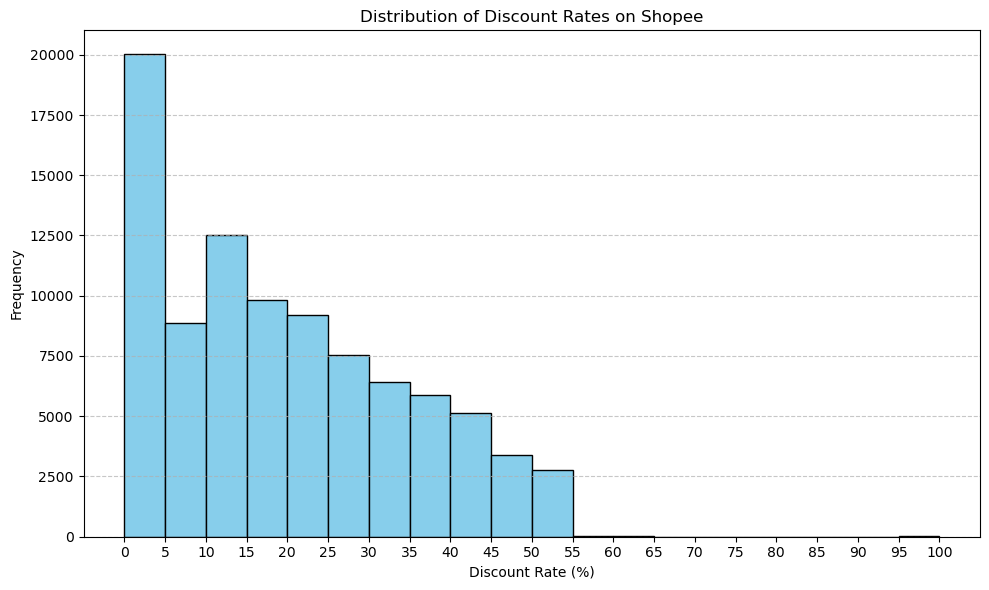

In [133]:
bins = np.arange(0, 105, 5) 
plt.figure(figsize=(10, 6))
plt.hist(df['discount'], bins=bins, color='skyblue', edgecolor='black')
plt.title('Distribution of Discount Rates on Shopee')
plt.xlabel('Discount Rate (%)')
plt.ylabel('Frequency')
plt.xticks(bins)  # Ensure x-axis ticks are set to bin edges
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [134]:
# # Calculate the average discount per day
# avg_discount_per_day = df.groupby('date')['discount'].mean().reset_index()

# # Special sale dates
# special_dates = {
#     '2024-03-15': 'SALE GIỮA THÁNG (15/3)',
#     '2024-03-25': 'LƯƠNG VỀ SALE TO (25/3)',
#     '2024-04-04': 'Shopee 4.4 (4/4)'
# }

# # Plotting
# plt.figure(figsize=(12, 6))
# plt.plot(avg_discount_per_day['date'], avg_discount_per_day['discount'], label='Average Discount', color='blue', marker='o')
# for date, label in special_dates.items():
#     plt.axvline(pd.to_datetime(date), color='red', linestyle='--', linewidth=1)
#     plt.text(pd.to_datetime(date), plt.ylim()[1]  - 0.1, label, horizontalalignment='right', color='red')

# plt.title('Average Discount Trends on Shopee with Special Sale Days Highlighted')
# plt.xlabel('Date')
# plt.ylabel('Average Discount (%)')
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m')) 
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()
# plt.legend()
# plt.show()

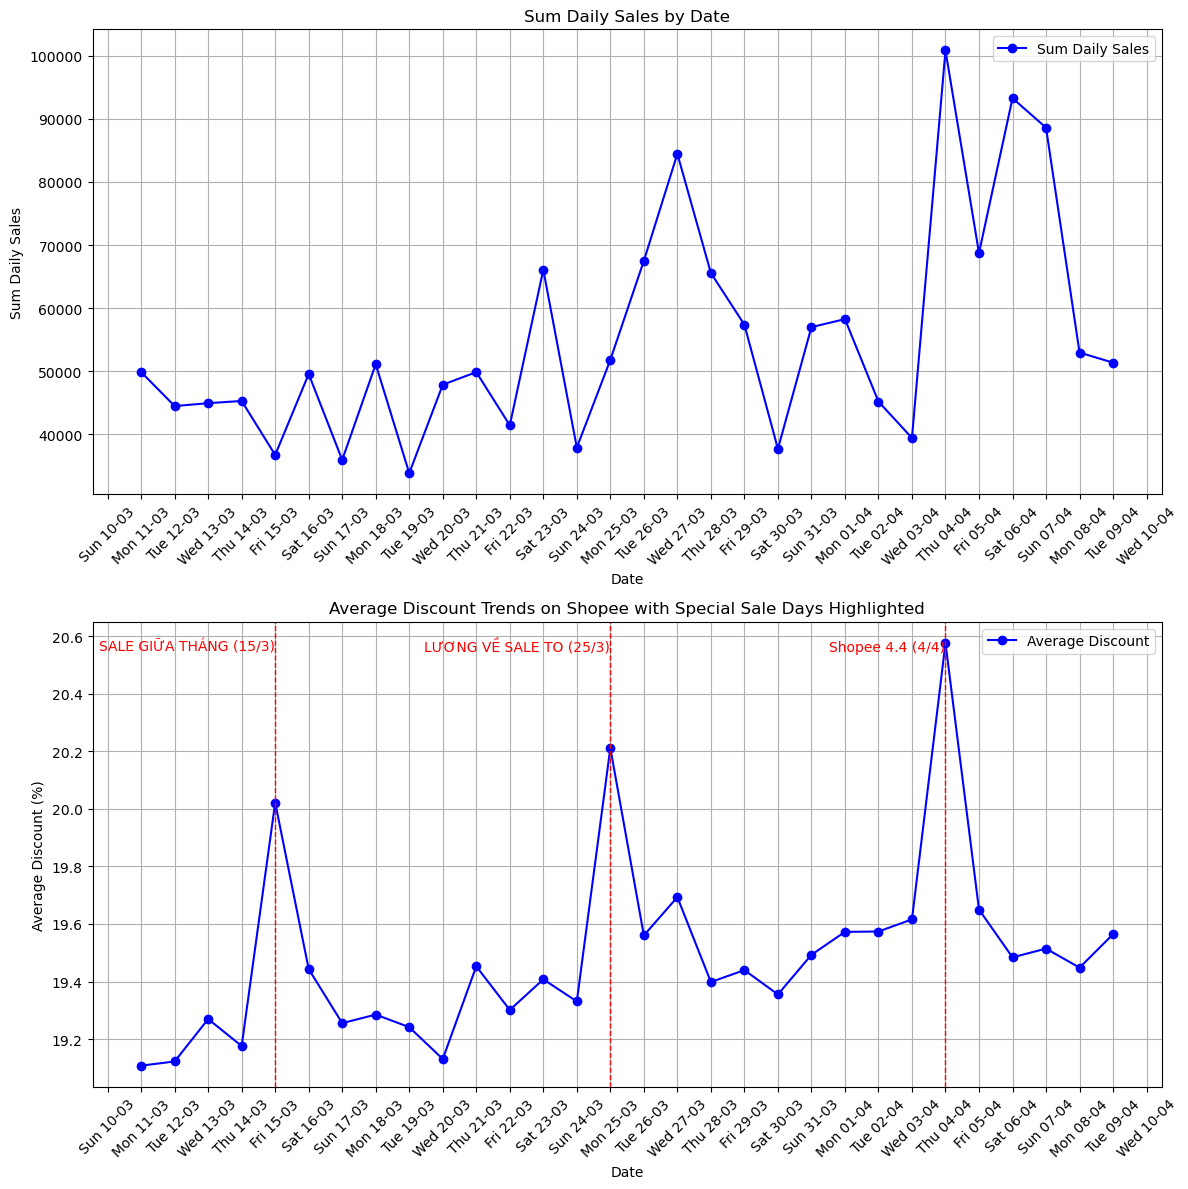

In [93]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Giả sử df là DataFrame chứa dữ liệu của bạn

# Bảng 1: Tính tổng doanh số hàng ngày
sum_daily_sales = df.groupby('date')['daily_sales'].sum().reset_index()

# Bảng 2: Tính trung bình discount mỗi ngày
avg_discount_per_day = df.groupby('date')['discount'].mean().reset_index()

# Ngày giảm giá đặc biệt
special_dates = {
    '2024-03-15': 'SALE GIỮA THÁNG (15/3)',
    '2024-03-25': 'LƯƠNG VỀ SALE TO (25/3)',
    '2024-04-04': 'Shopee 4.4 (4/4)'
}

# Tạo subplot với 2 hàng và 1 cột
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Biểu đồ 1: Tổng doanh số hàng ngày
axs[0].plot(sum_daily_sales['date'], sum_daily_sales['daily_sales'], label='Sum Daily Sales', color='blue', marker='o')
axs[0].set_title('Sum Daily Sales by Date')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Sum Daily Sales')
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval=1))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%a %d-%m'))
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(True)
axs[0].legend()

# Biểu đồ 2: Trung bình discount mỗi ngày với ngày giảm giá đặc biệt
axs[1].plot(avg_discount_per_day['date'], avg_discount_per_day['discount'], label='Average Discount', color='blue', marker='o')
for date, label in special_dates.items():
    axs[1].axvline(pd.to_datetime(date), color='red', linestyle='--', linewidth=1)
    axs[1].text(pd.to_datetime(date), axs[1].get_ylim()[1] - 0.1, label, horizontalalignment='right', color='red')
axs[1].set_title('Average Discount Trends on Shopee with Special Sale Days Highlighted')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Average Discount (%)')
axs[1].xaxis.set_major_locator(mdates.DayLocator(interval=1))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%a %d-%m'))
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()


In [136]:
df.columns

Index(['itemid', 'shopid', 'liked_count', 'discount', 'shop_location',
       'shop_rating', 'name', 'historical_sold', 'price', 'rating_star',
       'rating_count', 'rcount_with_context', 'date', 'date_of_week', 'day',
       'is_special_day', 'future_special_day', 'daily_sales',
       'daily_sales_lag_1d', 'price_lag_1d', 'daily_sales_lag_2d',
       'price_lag_2d', 'daily_sales_lag_3d', 'price_lag_3d',
       'daily_sales_lag_4d', 'price_lag_4d', 'daily_sales_lag_5d',
       'price_lag_5d', 'daily_sales_lag_6d', 'price_lag_6d',
       'daily_sales_lag_7d', 'price_lag_7d', 'sales_predict_day',
       'rolling_min_7d', 'rolling_max_7d', 'rolling_mean_7d', 'rolling_std_7d',
       'label_0_count', 'label_1_count', 'label_2_count',
       'enhanced_popularity_score', 'min_discount_in_train',
       'discount_to_min_discount', 'sales_quantile', 'no_sales_ratio_quantile',
       'Group-ID'],
      dtype='object')

c:\Users\ducli\miniconda3\envs\KLTN\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ducli\miniconda3\envs\KLTN\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ducli\miniconda3\envs\KLTN\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ducli\miniconda3\envs\KLTN\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

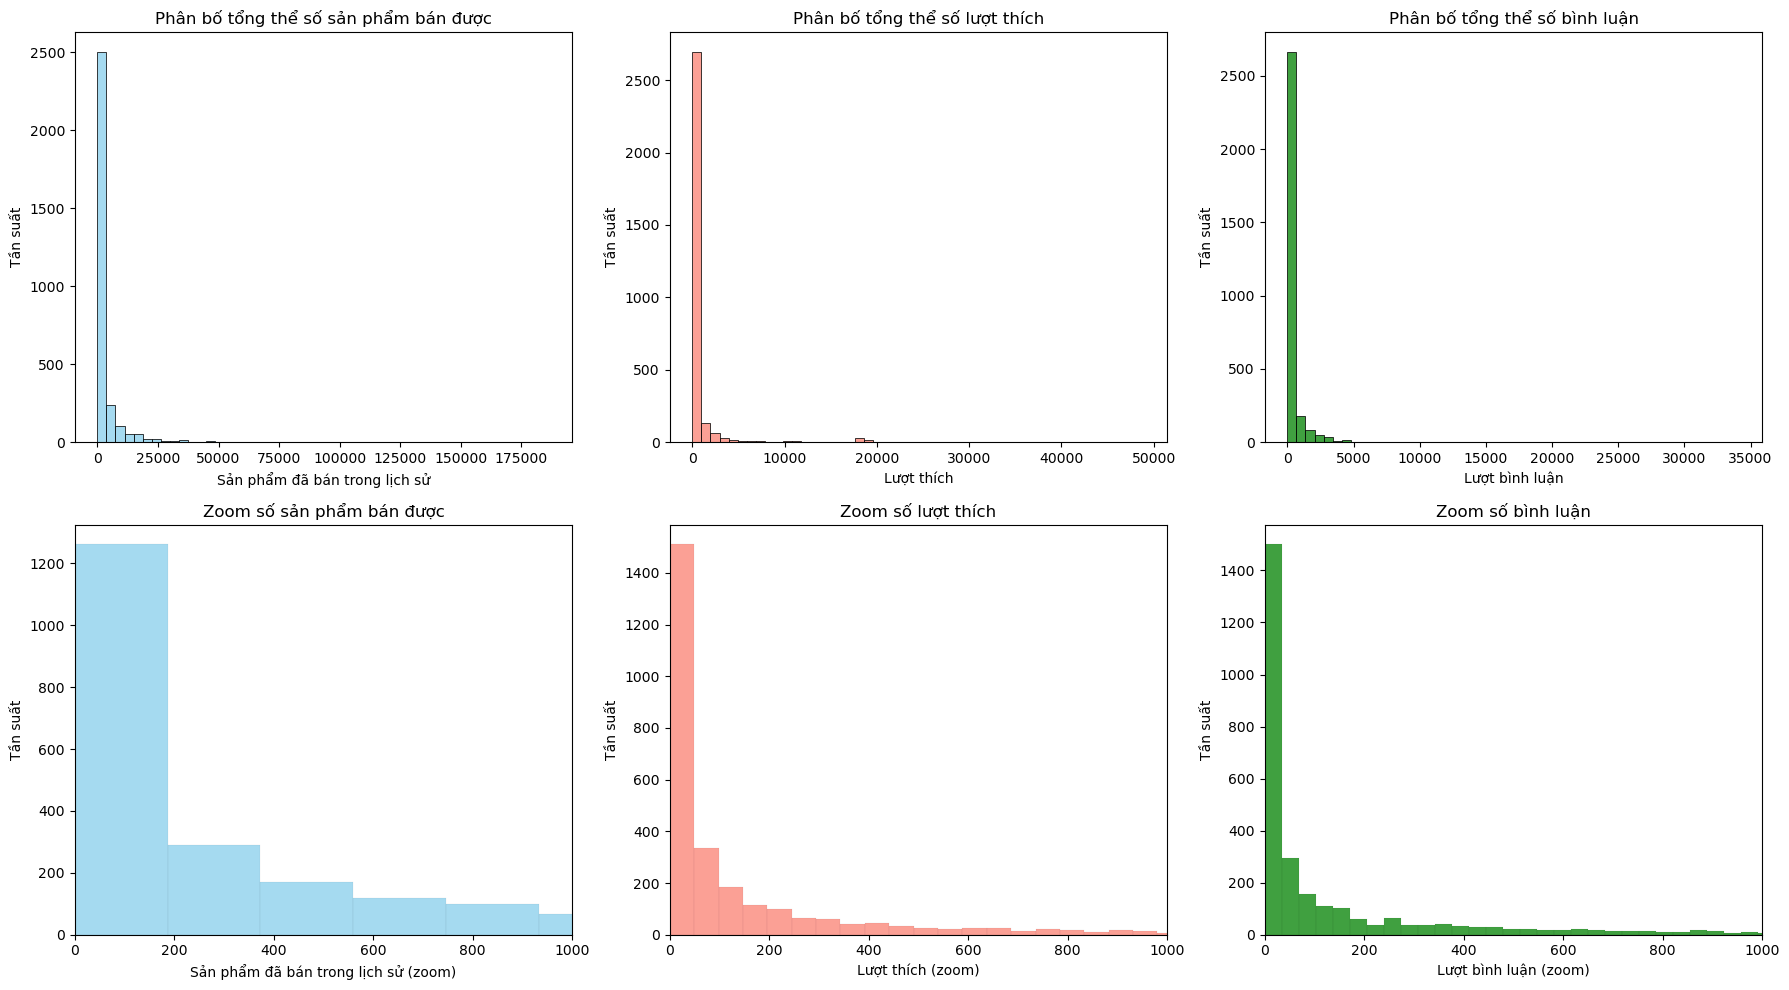

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create DataFrame
df = pd.DataFrame(df_copy.copy())

df = df.sort_values(by='date')
df = df.drop_duplicates(subset=['itemid'], keep='first')

# Biểu đồ phân bố số sản phẩm bán được, số lượt thích và số bình luận
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

# Phân bố tổng thể số sản phẩm bán được
sns.histplot(df['historical_sold'], bins=50, ax=ax[0, 0], color='skyblue')
ax[0, 0].set_title('Phân bố tổng thể số sản phẩm bán được')
ax[0, 0].set_xlabel('Sản phẩm đã bán trong lịch sử')
ax[0, 0].set_ylabel('Tần suất')

# Phân bố tổng thể số lượt thích
sns.histplot(df['liked_count'], bins=50, ax=ax[0, 1], color='salmon')
ax[0, 1].set_title('Phân bố tổng thể số lượt thích')
ax[0, 1].set_xlabel('Lượt thích')
ax[0, 1].set_ylabel('Tần suất')

# Phân bố tổng thể số bình luận
sns.histplot(df['rcount_with_context'], bins=50, ax=ax[0, 2], color='green')
ax[0, 2].set_title('Phân bố tổng thể số bình luận')
ax[0, 2].set_xlabel('Lượt bình luận')
ax[0, 2].set_ylabel('Tần suất')

# Zoom in biểu đồ số sản phẩm bán được
sns.histplot(df['historical_sold'], bins=1000, ax=ax[1, 0], color='skyblue')
ax[1, 0].set_xlim(0, 1000)
ax[1, 0].set_title('Zoom số sản phẩm bán được')
ax[1, 0].set_xlabel('Sản phẩm đã bán trong lịch sử (zoom)')
ax[1, 0].set_ylabel('Tần suất')

# Zoom in biểu đồ số lượt thích
sns.histplot(df['liked_count'], bins=1000, ax=ax[1, 1], color='salmon')
ax[1, 1].set_xlim(0, 1000)
ax[1, 1].set_title('Zoom số lượt thích')
ax[1, 1].set_xlabel('Lượt thích (zoom)')
ax[1, 1].set_ylabel('Tần suất')

# Zoom in biểu đồ số bình luận
sns.histplot(df['rcount_with_context'], bins=1000, ax=ax[1, 2], color='green')
ax[1, 2].set_xlim(0, 1000)
ax[1, 2].set_title('Zoom số bình luận')
ax[1, 2].set_xlabel('Lượt bình luận (zoom)')
ax[1, 2].set_ylabel('Tần suất')

plt.tight_layout()
plt.show()


In [138]:
column_to_corr = ['daily_sales', 'itemid', 'shopid', 'liked_count', 'rcount_with_context', 'discount', 'shop_rating', 'historical_sold', 'price', 'rating_star', 'rating_count']

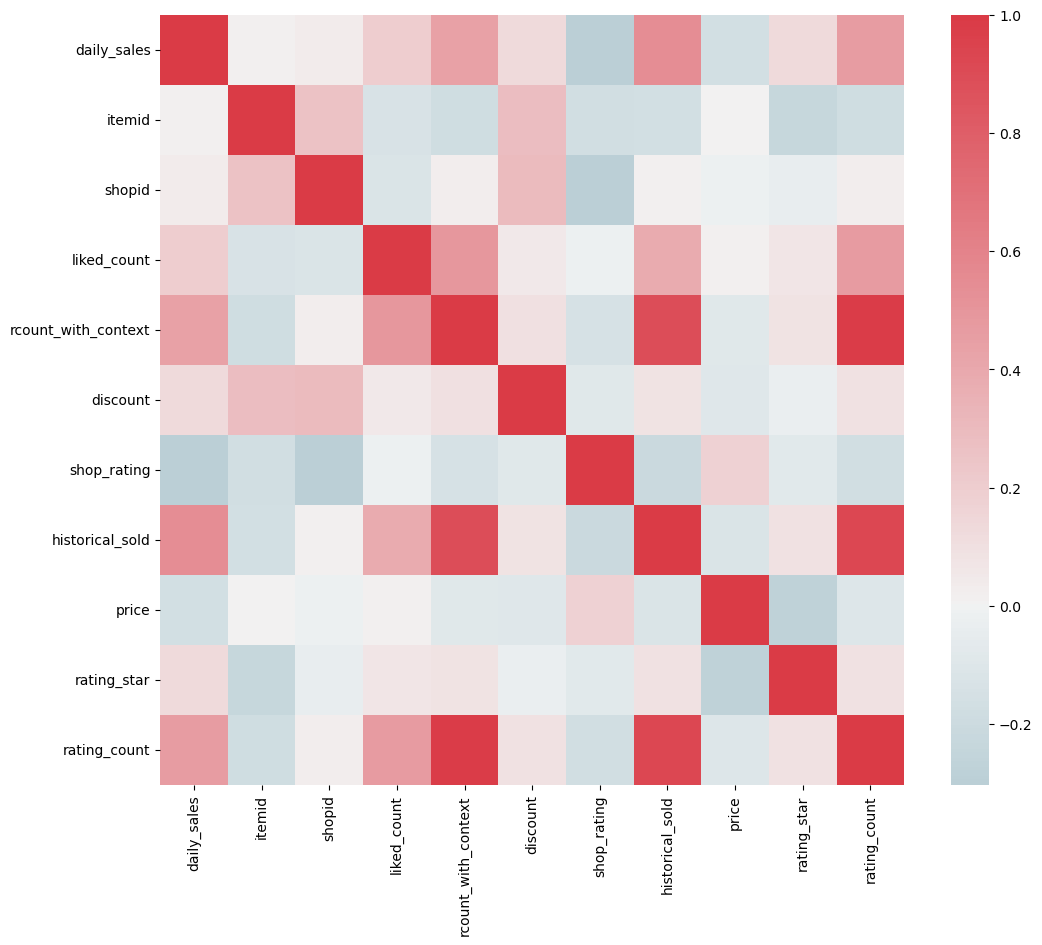

In [139]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Calculate the correlation matrix
corr = df[column_to_corr].corr()

# Create a heatmap
plt.figure(figsize=(12, 10))  # Adjust the size as needed
sns.heatmap(corr, annot=False, cmap=cmap, center=0)
plt.show()

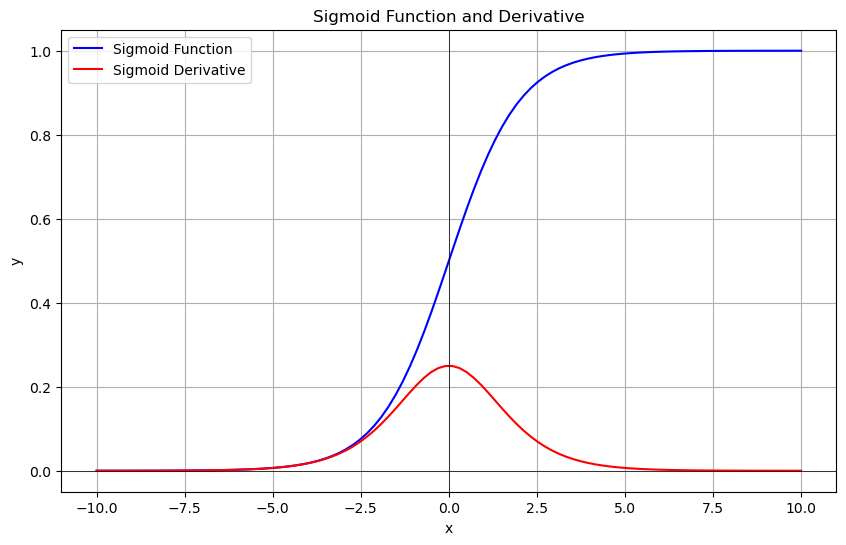

In [140]:
import numpy as np
import matplotlib.pyplot as plt

# Defining the functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
# Generating a range of values
x = np.linspace(-10, 10, 100)

# Computing the function values
y_sigmoid = sigmoid(x)

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

# Computing the derivative values
y_sigmoid_derivative = sigmoid_derivative(x)

# Kết hợp cả hai biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(x, y_sigmoid, label='Sigmoid Function', color='blue')
plt.plot(x, y_sigmoid_derivative, label='Sigmoid Derivative', color='red')
plt.title('Sigmoid Function and Derivative')
plt.xlabel('x')
plt.ylabel('y')
plt.axhline(y=0, color='black', linewidth=0.5)
plt.axvline(x=0, color='black', linewidth=0.5)
plt.grid(True)
plt.legend()
plt.show()

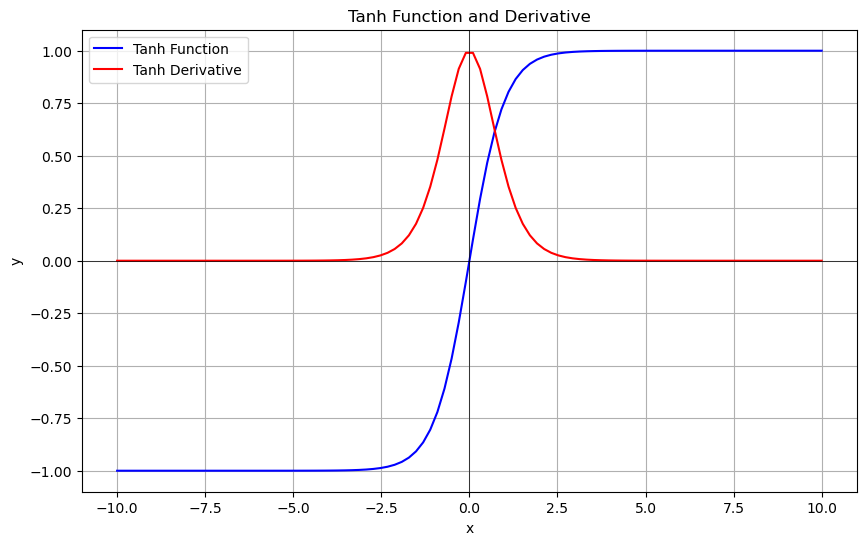

In [141]:
#Hàm tanh
def tanh(x):
    return np.tanh(x)

# Computing the function values
y_tanh = tanh(x)
y_tanh_derivative = 1 - np.square(y_tanh)

# Creating the tanh and its derivative plots
plt.figure(figsize=(10, 6))
plt.plot(x, y_tanh, label='Tanh Function', color='blue')
plt.plot(x, y_tanh_derivative, label='Tanh Derivative', color='red')
plt.title('Tanh Function and Derivative')
plt.xlabel('x')
plt.ylabel('y')
plt.axhline(y=0, color='black', linewidth=0.5)
plt.axvline(x=0, color='black', linewidth=0.5)
plt.grid(True)
plt.legend()
plt.show()


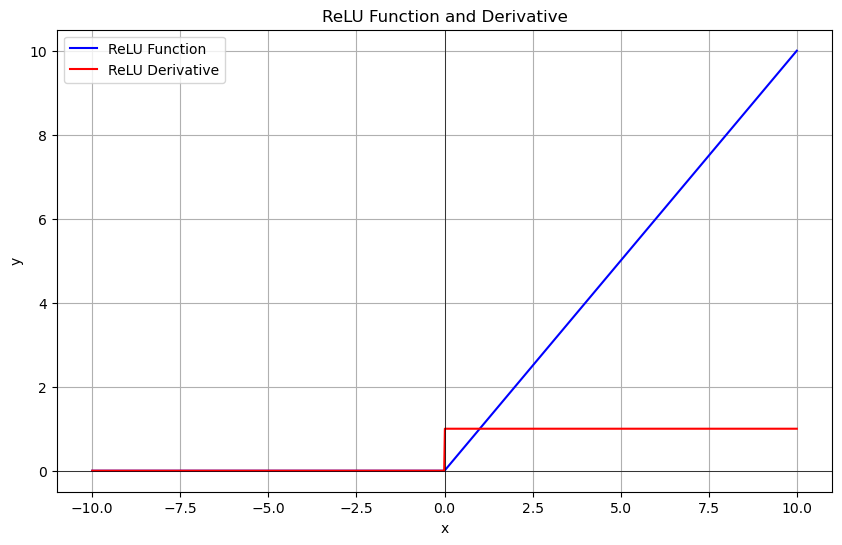

In [142]:
# Hàm ReLU
def relu(x):
    return np.maximum(0, x)
x = np.linspace(-10, 10, 1000)

# Computing the function values
y_relu = relu(x)
y_relu_derivative = np.where(x > 0, 1, 0)


# Creating the ReLU and its derivative plots
plt.figure(figsize=(10, 6))
plt.plot(x, y_relu, label='ReLU Function', color='blue')
plt.plot(x, y_relu_derivative, label='ReLU Derivative', color='red')
plt.title('ReLU Function and Derivative')
plt.xlabel('x')
plt.ylabel('y')
plt.axhline(y=0, color='black', linewidth=0.5)
plt.axvline(x=0, color='black', linewidth=0.5)
plt.grid(True)
plt.legend()
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


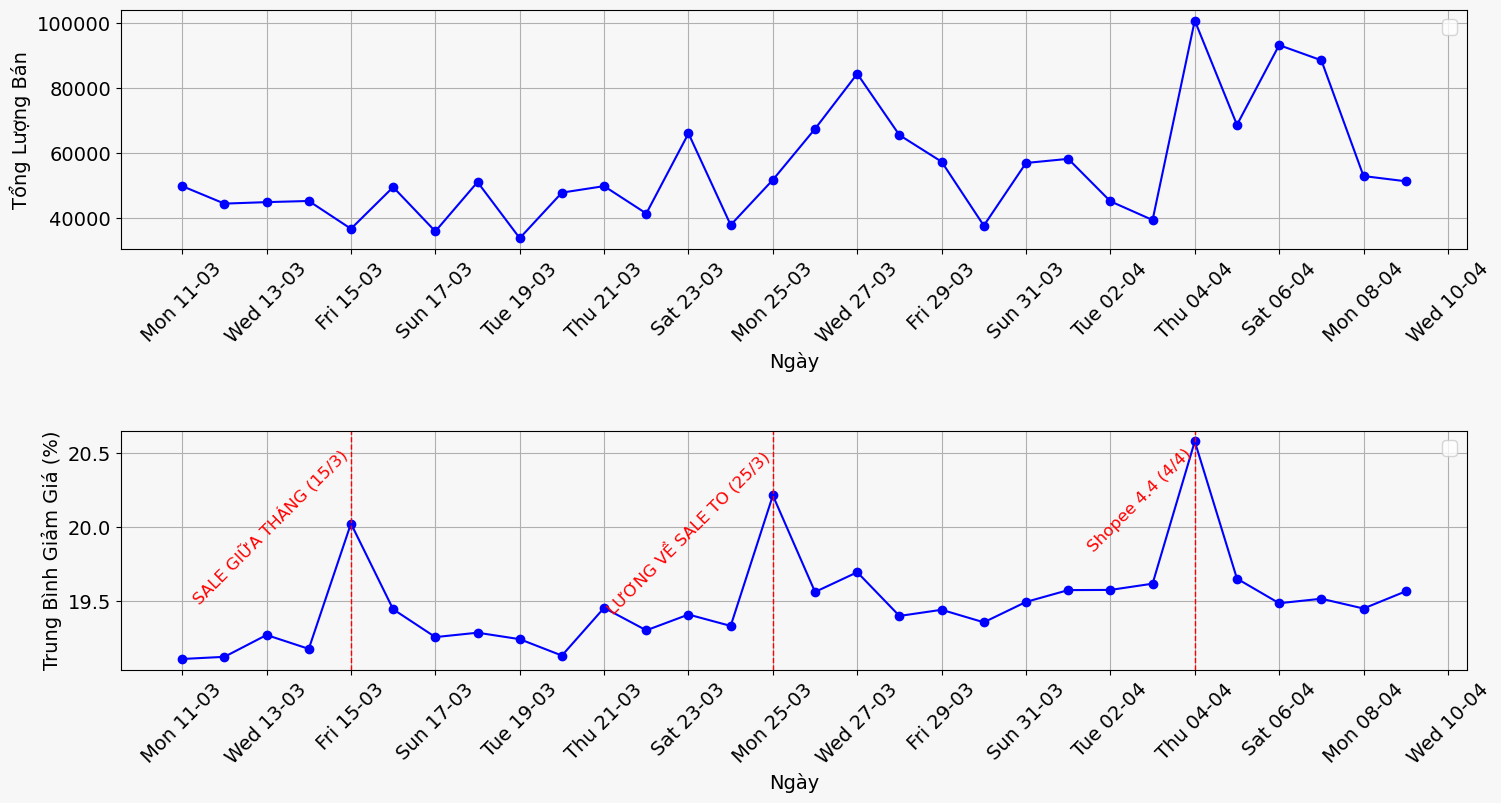

In [104]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Giả sử df là DataFrame chứa dữ liệu của bạn

# Bảng 1: Tính tổng doanh số hàng ngày
tong_doanh_so_hang_ngay = df.groupby('date')['daily_sales'].sum().reset_index()

# Bảng 2: Tính trung bình giảm giá mỗi ngày
trung_binh_giam_gia_hang_ngay = df.groupby('date')['discount'].mean().reset_index()

# Ngày giảm giá đặc biệt
ngay_giam_gia_dac_biet = {
    '2024-03-15': 'SALE GIỮA THÁNG (15/3)',
    '2024-03-25': 'LƯƠNG VỀ SALE TO (25/3)',
    '2024-04-04': 'Shopee 4.4 (4/4)'
}

# Tạo subplot với 2 hàng và 1 cột
fig, axs = plt.subplots(2, 1, figsize=(16, 9), facecolor='#f7f7f7')

# Thiết lập nền cho từng biểu đồ
for ax in axs:
    ax.set_facecolor('#f7f7f7')

# Tăng cỡ chữ
plt.rcParams.update({'font.size': 14})

# Biểu đồ 1: Tổng doanh số hàng ngày
axs[0].plot(tong_doanh_so_hang_ngay['date'], tong_doanh_so_hang_ngay['daily_sales'], color='blue', marker='o')
axs[0].set_ylabel('Tổng Lượng Bán', fontsize=14)
axs[0].set_xlabel('Ngày', fontsize=14)
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval=2))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%a %d-%m'))
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(True)
axs[0].legend()

# Biểu đồ 2: Trung bình giảm giá mỗi ngày với ngày giảm giá đặc biệt
axs[1].plot(trung_binh_giam_gia_hang_ngay['date'], trung_binh_giam_gia_hang_ngay['discount'],  color='blue', marker='o')
for date, label in ngay_giam_gia_dac_biet.items():
    axs[1].axvline(pd.to_datetime(date), color='red', linestyle='--', linewidth=1)
    axs[1].text(pd.to_datetime(date), axs[1].get_ylim()[1] - 0.1, label, horizontalalignment='right', verticalalignment='top', rotation=45, color='red', fontsize=12)
axs[1].set_ylabel('Trung Bình Giảm Giá (%)', fontsize=14)
axs[1].set_xlabel('Ngày', fontsize=14)
axs[1].xaxis.set_major_locator(mdates.DayLocator(interval=2))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%a %d-%m'))
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(True)
axs[1].legend()

plt.tight_layout(pad=3.0)
plt.show()
